# VAE Hyperparameter Tuning for Fraud Detection

This notebook performs grid search hyperparameter tuning for the VAE model using the `VAEGridSearchTuner` class.

## Objectives
1. Define parameter grid for tuning
2. Train multiple VAE configurations
3. Compare performance across hyperparameters
4. Identify best configuration
5. Compare best VAE against baseline models

## Hyperparameters to Tune
- **Hidden Dimension**: Network capacity
- **Latent Dimension**: Bottleneck size
- **Beta**: KL divergence weight
- **Learning Rate**: Optimization speed

In [9]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import confusion_matrix

from src.vae_models.vae_tuner import VAEGridSearchTuner
from src.evaluation import FraudEvaluationMetrics

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER


## 1. Define Base Configuration and Parameter Grid

In [10]:
# Base configuration (parameters that won't change)
base_config = {
    # Data
    'data_path': '../../data/processed/creditcard_fe.csv',
    'drop_features': 'logreg_baseline',  # Use same features as logistic regression
    
    # Fixed training parameters
    'epochs': 100,
    'batch_size': 256,
    
    # Business costs (CORRECTED per project spec)
    'C_FP': 550,  # False positive cost (investigation)
    'C_FN': 110,  # False negative cost (missed fraud)
    
    # Hardware
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'random_seed': 42,
    
    # Save directories
    'model_save_dir': '../../models/',
    'results_save_dir': '../../results/tuning/'
}

# Parameter grid to search
param_grid = {
    'hidden_dim': [64, 128, 256],      # Network capacity
    'latent_dim': [8, 16, 32],         # Bottleneck size
    'beta': [0.5, 1.0, 2.0],           # KL weight
    'learning_rate': [1e-3, 1e-4]      # Optimization speed
}

# Calculate total configurations
total_configs = np.prod([len(v) for v in param_grid.values()])

print("Hyperparameter Tuning Configuration")
print("=" * 60)
print(f"\nBase Configuration:")
for key, value in base_config.items():
    print(f"  {key:20s}: {value}")

print(f"\nParameter Grid:")
for key, values in param_grid.items():
    print(f"  {key:20s}: {values}")

print(f"\nTotal Configurations: {total_configs}")
print(f"Estimated Time (5 min/config): ~{total_configs * 5} minutes")

Hyperparameter Tuning Configuration

Base Configuration:
  data_path           : ../../data/processed/creditcard_fe.csv
  drop_features       : logreg_baseline
  epochs              : 100
  batch_size          : 256
  C_FP                : 550
  C_FN                : 110
  device              : cuda
  random_seed         : 42
  model_save_dir      : ../../models/
  results_save_dir    : ../../results/tuning/

Parameter Grid:
  hidden_dim          : [64, 128, 256]
  latent_dim          : [8, 16, 32]
  beta                : [0.5, 1.0, 2.0]
  learning_rate       : [0.001, 0.0001]

Total Configurations: 54
Estimated Time (5 min/config): ~270 minutes


## 2. Run Grid Search

This will train all configurations and track results. The best model (by validation cost) will be automatically saved.

In [11]:
results_csv_path = '../../results/tuning/grid_search_results.csv'

if os.path.exists(results_csv_path):
    print("=" * 70)
    print("LOADING PRE-COMPUTED GRID SEARCH RESULTS")
    print("=" * 70)
    
    # Load results CSV
    results_df = pd.read_csv(results_csv_path)
    
    print(f"\n✓ Successfully loaded {len(results_df)} configurations")
    print(f"✓ Best validation cost: ${results_df['val_cost'].min():,.0f}")
    print(f"✓ Best test cost: ${results_df['test_cost'].min():,.0f}")
    
    # Show best configuration
    best_idx = results_df['val_cost'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION (by validation cost):")
    print(f"{'='*70}")
    print(f"  Config Index:     {int(best_config['config_idx'])}")
    print(f"  Hidden Dim:       {int(best_config['hidden_dim'])}")
    print(f"  Latent Dim:       {int(best_config['latent_dim'])}")
    print(f"  Beta:             {best_config['beta']}")
    print(f"  Learning Rate:    {best_config['learning_rate']}")
    print(f"\n  Validation Cost:  ${int(best_config['val_cost']):,}")
    print(f"  Test Cost:        ${int(best_config['test_cost']):,}")
    print(f"  Precision:        {best_config['test_precision']:.3f}")
    print(f"  Recall:           {best_config['test_recall']:.3f}")
    print(f"  PR-AUC:           {best_config['test_pr_auc']:.4f}")
    
    print(f"\n{'='*70}")
    print("✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)")
    print(f"{'='*70}")
else:
    print(f"❌ Results not found at: {results_csv_path}")
    print("Please run Option B below to generate results (takes ~4 hours).")

LOADING PRE-COMPUTED GRID SEARCH RESULTS

✓ Successfully loaded 54 configurations
✓ Best validation cost: $15,070
✓ Best test cost: $16,060

BEST CONFIGURATION (by validation cost):
  Config Index:     44
  Hidden Dim:       256
  Latent Dim:       16
  Beta:             0.5
  Learning Rate:    0.0001

  Validation Cost:  $15,070
  Test Cost:        $18,700
  Precision:        0.941
  Recall:           0.451
  PR-AUC:           0.6939

✓ Ready to analyze! Skip to Section 3 (Analyze Tuning Results)


### Run Full Grid Search (Takes ~4 hours)

In [ ]:
# tuner = VAEGridSearchTuner(
#     base_config=base_config,
#     param_grid=param_grid,
#     results_dir='../../results/tuning/'
# )

# results_df = tuner.run_grid_search()

In [12]:
# Display top 10 configurations by test cost
print("\n" + "="*70)
print("TOP 10 CONFIGURATIONS BY TEST COST")
print("="*70)

top10 = results_df.nsmallest(10, 'test_cost')[[
    'config_idx', 'hidden_dim', 'latent_dim', 'beta', 'learning_rate',
    'test_cost', 'test_precision', 'test_recall', 'test_pr_auc'
]].copy()

# Format for display
top10['test_cost'] = top10['test_cost'].apply(lambda x: f"${int(x):,}")
top10['test_precision'] = top10['test_precision'].apply(lambda x: f"{x:.3f}")
top10['test_recall'] = top10['test_recall'].apply(lambda x: f"{x:.3f}")
top10['test_pr_auc'] = top10['test_pr_auc'].apply(lambda x: f"{x:.4f}")

print(top10.to_string(index=False))


TOP 10 CONFIGURATIONS BY TEST COST
 config_idx  hidden_dim  latent_dim  beta  learning_rate test_cost test_precision test_recall test_pr_auc
         45         256          16   1.0         0.0010   $16,060          0.934       0.630      0.7664
         54         256          32   2.0         0.0001   $16,390          0.982       0.435      0.6112
         28         128          16   1.0         0.0001   $16,720          0.966       0.463      0.6524
         14          64          32   0.5         0.0001   $16,830          0.973       0.439      0.7406
         49         256          32   0.5         0.0010   $16,830          0.981       0.419      0.7507
         46         256          16   1.0         0.0001   $17,050          0.959       0.472      0.6591
         31         128          32   0.5         0.0010   $17,270          0.972       0.423      0.7468
         32         128          32   0.5         0.0001   $17,600          0.957       0.451      0.7095
         5

In [13]:
# Summary statistics
print("\n" + "="*70)
print("TUNING SUMMARY STATISTICS")
print("="*70)

print(f"\nTest Cost:")
print(f"  Best: ${results_df['test_cost'].min():,.0f}")
print(f"  Worst: ${results_df['test_cost'].max():,.0f}")
print(f"  Mean: ${results_df['test_cost'].mean():,.0f}")
print(f"  Std Dev: ${results_df['test_cost'].std():,.0f}")

print(f"\nPrecision:")
print(f"  Best: {results_df['test_precision'].max():.3f}")
print(f"  Worst: {results_df['test_precision'].min():.3f}")
print(f"  Mean: {results_df['test_precision'].mean():.3f}")

print(f"\nRecall:")
print(f"  Best: {results_df['test_recall'].max():.3f}")
print(f"  Worst: {results_df['test_recall'].min():.3f}")
print(f"  Mean: {results_df['test_recall'].mean():.3f}")

print(f"\nPR-AUC:")
print(f"  Best: {results_df['test_pr_auc'].max():.4f}")
print(f"  Worst: {results_df['test_pr_auc'].min():.4f}")
print(f"  Mean: {results_df['test_pr_auc'].mean():.4f}")


TUNING SUMMARY STATISTICS

Test Cost:
  Best: $16,060
  Worst: $30,140
  Mean: $21,448
  Std Dev: $3,062

Precision:
  Best: 0.984
  Worst: 0.750
  Mean: 0.934

Recall:
  Best: 0.630
  Worst: 0.163
  Mean: 0.318

PR-AUC:
  Best: 0.7670
  Worst: 0.4406
  Mean: 0.6332


## 4. Impact of Individual Hyperparameters

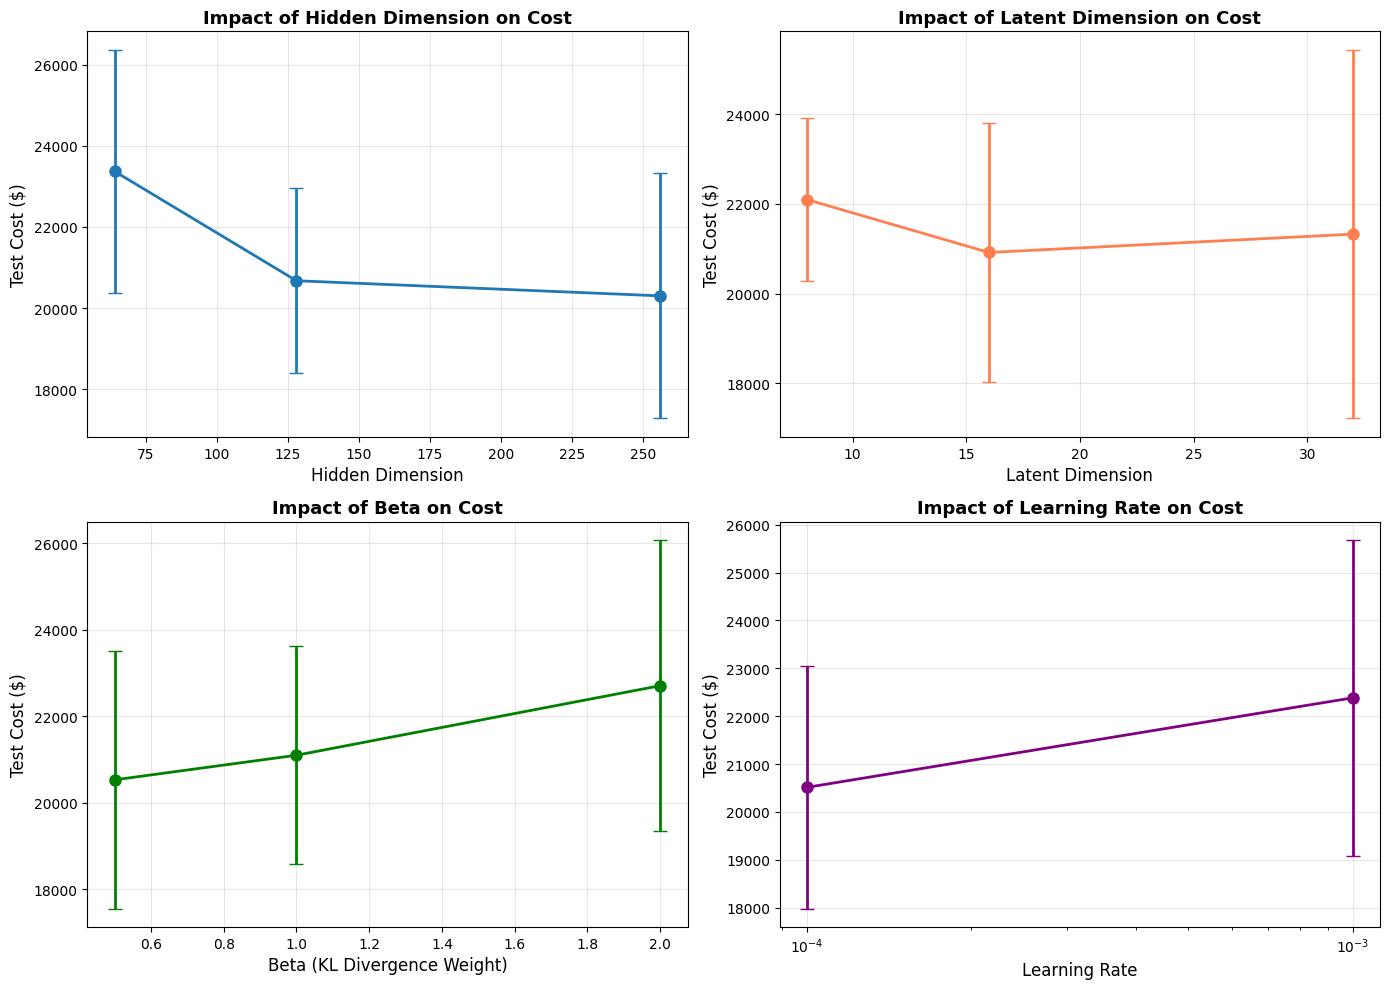


Hyperparameter impact plot saved: results/figures/hyperparameter_impact_analysis.png


In [14]:
# Analyze impact of each hyperparameter on test cost
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hidden Dimension
ax = axes[0, 0]
grouped = results_df.groupby('hidden_dim')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8)
ax.set_xlabel('Hidden Dimension', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Hidden Dimension on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Latent Dimension
ax = axes[0, 1]
grouped = results_df.groupby('latent_dim')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Latent Dimension', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Latent Dimension on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Beta (KL Weight)
ax = axes[1, 0]
grouped = results_df.groupby('beta')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='green')
ax.set_xlabel('Beta (KL Divergence Weight)', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Beta on Cost', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Learning Rate
ax = axes[1, 1]
grouped = results_df.groupby('learning_rate')['test_cost'].agg(['mean', 'std', 'min', 'max'])
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
            marker='o', capsize=5, linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Test Cost ($)', fontsize=12)
ax.set_title('Impact of Learning Rate on Cost', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/hyperparameter_impact_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nHyperparameter impact plot saved: results/figures/hyperparameter_impact_analysis.png")

## 5. Hyperparameter Interaction Analysis

In [15]:
# Get best configuration results (based on validation cost)
best_idx = results_df['val_cost'].idxmin()
best_config = results_df.loc[best_idx]

print("\n" + "="*70)
print("BEST TUNED VAE CONFIGURATION")
print("="*70)
print(f"\nHyperparameters:")
print(f"  Hidden Dimension: {int(best_config['hidden_dim'])}")
print(f"  Latent Dimension: {int(best_config['latent_dim'])}")
print(f"  Beta: {best_config['beta']}")
print(f"  Learning Rate: {best_config['learning_rate']}")

print(f"\nPerformance:")
print(f"  Validation Cost: ${int(best_config['val_cost']):,}")
print(f"  Test Cost: ${int(best_config['test_cost']):,}")
print(f"  Precision: {best_config['test_precision']:.3f}")
print(f"  Recall: {best_config['test_recall']:.3f}")
print(f"  PR-AUC: {best_config['test_pr_auc']:.4f}")
print(f"  False Positives: {int(best_config['test_fp'])}")
print(f"  False Negatives: {int(best_config['test_fn'])}")


BEST TUNED VAE CONFIGURATION

Hyperparameters:
  Hidden Dimension: 256
  Latent Dimension: 16
  Beta: 0.5
  Learning Rate: 0.0001

Performance:
  Validation Cost: $15,070
  Test Cost: $18,700
  Precision: 0.941
  Recall: 0.451
  PR-AUC: 0.6939
  False Positives: 7
  False Negatives: 135
